In [6]:
import pandas as pd
from smartsheet_dataframe import get_as_df
import os

In [7]:
# Storing Smartsheet information in variables
shitz_token = "wMvGniITjDFd7ClZPE44wtJGvZkM7Hg7mP7if" #Bily's personal token to access G-A smartsheet data. Anyone can obtain their own token
fhaid = 4523924143794052 # The ID number that references the FHA sheet
mssid = 3005704744265604 # The ID number that references the MSS sheet

# Creating the FHA and MSS dataframes
fha_df = get_as_df(type_='sheet',
                  token=shitz_token,
                  id_=fhaid)

mss_df = get_as_df(type_='sheet',
                  token=shitz_token,
                  id_=mssid)

# data_df = mss_df.loc[(mss_df['UniqueID'].str.contains('WAR')) |
#                     (mss_df['UniqueID'].str.contains('WRR')) |
#                     (mss_df['UniqueID'].str.contains('BJT'))].copy()
data_df = mss_df.copy()

data_df['Tract'] = data_df['Tract'].astype(str).apply(lambda x: x.split('.')[0])
data_df['CMP'] = data_df['CMP'].astype(str).apply(lambda x: x.split('.')[0])
data_df['Stand'] = data_df['Stand'].astype(str).apply(lambda x: x.split('.')[0])
data_df['TCS'] = data_df['Tract'] + "_" + data_df['CMP'] + "_" + data_df['Stand']

data_df['Reporting Period'] = data_df['Reporting Period'].fillna(0)
data_df.loc[data_df['Reporting Period'] == "", 'Reporting Period'] = 0
data_df['Reporting Period'] = data_df['Reporting Period'].astype(str)
s = data_df.loc[pd.to_numeric(data_df['Reporting Period'], errors='coerce').isnull() & data_df['Reporting Period'].str.contains("RP"), 'Reporting Period'].apply(lambda x: x.strip()[-1])
data_df['trial'] = data_df.index.map(s)
data_df.loc[pd.to_numeric(data_df['Reporting Period'], errors='coerce').isnull() & data_df['Reporting Period'].str.contains("RP"), 'Reporting Period'] = data_df.loc[pd.to_numeric(data_df['Reporting Period'], errors='coerce').isnull() & data_df['Reporting Period'].str.contains("RP"), 'trial']
data_df['Reporting Period'] = pd.to_numeric(data_df['Reporting Period'], downcast='integer')
data_df['Future GT'] = pd.to_numeric(data_df['Future GT'], errors='coerce')


## Creaet Client Table

In [8]:
# Filter out the Client Provided data and make sure the fields are similar
client_df = data_df[['UniqueID',
                    'Tract',
                    'CMP',
                    'Stand',
                    'Acres',
                    'Age',
                    'County',
                    'State',
                    'Species',
                    'Origin',
                    'Scheduled',
                    'PreBA',
                    'PreTPA',
                    'PreGTA',
                    'PlnBA',
                    'PlnTPA',
                    'PlnGTA',
                    'Client GT',
                    'Future GT',
                    'Reporting Period']].copy()

client_df['Age'] = pd.to_numeric(client_df['Age'], errors='coerce', downcast='integer').fillna(0).astype(int)
client_df.loc[pd.to_numeric(client_df['Future GT'], errors='coerce').isnull(), 'Future GT'] = 0
client_df['Tract'] = client_df['Tract'].astype(str)
client_df['Stand'] = client_df['Stand'].astype(str)
client_df['Tract'] = client_df['Tract'].apply(lambda x: x.split('.')[0])
client_df['Client GT'] = pd.to_numeric(client_df['Client GT'], errors="coerce")
client_df['Client GT'] = client_df['Client GT'].fillna(0)

cols = ['PreBA', 'PreTPA', 'PreGTA', 'PlnBA', 'PlnTPA', 'PlnGTA']

for x in cols:
    client_df[x] = pd.to_numeric(client_df[x], errors='coerce', downcast='integer').fillna(-99).astype(int)



# Normalize some of the fields in the client intake table

## Normalize Species
species = ["Slash Pine", "Loblolly Pine", 'Mixed Natural Pine', 'Hardwood Mix', 'Pine Straw', "Other"]
species_dict = {'Species': species}
species_df = pd.DataFrame(species_dict)
species_df['Species_UID'] = species_df.index
species_df['Species'] = species_df['Species'].str.lower()

def species_map(x):
    x = x.lower()
    if "slash" in x:
        return 0
    elif "loblol" in x:
        return 1
    elif "mixed natural" in x:
        return 2
    elif "h" in x:
        return 3
    elif "straw" in x:
        return 4
    elif "pine" in x:
        return 1
    else:
        return 5
    
client_df['Species'] = client_df['Species'].apply(lambda x: species_map(x))


## Normalize origin
origins = ['Planted', 'Natural', 'Natural Mix', 'Other']
origin_dict = {'Origin': origins}
origin_df = pd.DataFrame(origin_dict)
origin_df['OriginUID'] = origin_df.index
origin_df['Origin'] = origin_df['Origin'].str.lower()

def origin_map(x):
    x = x.lower()
    if "plant" in x:
        return 0
    elif "natural mix" in x:
        return 2
    elif "nat" in x:
        return 1
    else:
        return 3
client_df['Origin'] = client_df['Origin'].apply(lambda x: origin_map(x))


## Normalize tract
client_df['tract_l'] = client_df['Tract'].apply(lambda x: x.lower())
tracts = client_df['tract_l'].unique().tolist()
tract_dict = {'tract': tracts}
tract_df = pd.DataFrame(tract_dict)
tract_df['tract_uid'] = tract_df.index
new_tract_dict = dict(zip(tract_df['tract'], tract_df['tract_uid']))
client_df['Tract'] = client_df['tract_l'].map(new_tract_dict)

## Normalize county
client_df['County'] = client_df['County'].astype(str)
client_df['county_l'] = client_df['County'].apply(lambda x: x.lower())
countys = client_df['county_l'].unique().tolist()
county_dict = {'county': countys}
county_df = pd.DataFrame(county_dict)
county_df['county_uid'] = county_df.index
new_county_dict = dict(zip(county_df['county'], county_df['county_uid']))
client_df['County'] = client_df['county_l'].map(new_county_dict)

## Normalize state
client_df['State'] = client_df['State'].astype(str)
client_df['state_l'] = client_df['State'].apply(lambda x: x.lower())
states = client_df['state_l'].unique().tolist()
state_dict = {'state': states}
state_df = pd.DataFrame(state_dict)
state_df['state_uid'] = state_df.index
new_state_dict = dict(zip(state_df['state'], state_df['state_uid']))
client_df['State'] = client_df['state_l'].map(new_state_dict)

# Drop the lowercase columns
client_df.drop(columns=['tract_l', 'county_l', 'state_l'], inplace=True)


## Create GA Intake Table

In [9]:
ga_intake_df = data_df[['IntakeID',
                       'FolderID',
                       'UniqueID',
                       'GA_ACRES',
                       'GA GT', # this is going to be GA total isn't it? Or does it stay as GA estimate of current GT (total minus what client says is future)
                       'Total GT', # This will be the conservative total between client and GA numbers
                       'Notes'
                       ]].copy()

# Lowercase the ga_intake_df column names
ga_intake_df.columns = [x.lower().replace(' ', '_') for x in ga_intake_df.columns]
ga_intake_df.rename(columns={'uniqueid': 'ga_uid'},inplace=True)
ga_intake_df = ga_intake_df[['ga_uid', 'intakeid', 'folderid', 'ga_acres', 'ga_gt', 'total_gt', 'notes']]


## Create Status Table

In [10]:
status_df = data_df[['UniqueID',
                    'Guidance',
                    'Expiration',
                    'GuidanceProvider',
                    'Status',
                    'Completed Date'
                    ]].copy()
status_df.rename(columns={'UniqueID': 'status_uid'}, inplace=True)

## Create TicketID -> UniqueID lookup table

In [11]:
ticketid_lookup_df = data_df[['UniqueID', 'TicketID']].copy() # the uniqueid will the the unique id for this table


In [12]:
ticketid_list = data_df['TicketID'].unique().tolist()
ticketid_dict = {'ticketid': ticketid_list}
ticketid_df = pd.DataFrame(ticketid_dict)
ticketid_df['ticketid_uid'] = ticketid_df.index
new_ticketid_dict = dict(zip(ticketid_df['ticketid'], ticketid_df['ticketid_uid']))
ticketid_lookup_df['ticketid'] = ticketid_lookup_df['TicketID'].map(new_ticketid_dict)

ticketid_lookup_df.rename(columns={'ticketid_uid': 'ticket_id',
                                    'UniqueID': 'ticket_lookup_uid'}, inplace=True)
ticketid_lookup_df.drop('TicketID', axis=1, inplace=True)

In [13]:
ticketid_lookup_df

,ticket_lookup_uid,ticketid
0,WAR241025HD09,0
1,WAR241025HD07,0
2,WAR241025HD06,0
3,WAR250620TH02,1
4,WAR250310BI03,2
...,...,...
840,WRR240109TT01,578
841,WRR240325BN01,579
842,WRR240318BN02,580
843,WRR240318BN01,581


## Create the TCS lookup


In [14]:
tcs_df = data_df.groupby('TicketID').agg({'Tract': 'first',
                                               'CMP': 'first',
                                               'Stand': ', '.join}).reset_index()

def split_stands(x):
    bugger_splot = list(set(x.split(', ')))
    bugger_splot.sort()
    return ", ".join(bugger_splot)
    
tcs_df['stands'] = tcs_df['Stand'].apply(split_stands)
tcs_df['comp'] = tcs_df['CMP'].apply(lambda x: x if x!="NP" else "")
tcs_df['TCS'] = tcs_df['Tract'] + "_" + tcs_df['comp'] + "_" + tcs_df['stands']
tcs_df['TCS'] = tcs_df['TCS'].apply(lambda x: x.replace("__", "_"))
tcs_df['tcs_uid'] = tcs_df.index
tcs_df = tcs_df[['tcs_uid', 'TicketID', 'TCS']].copy()

TicketID table should have a link to this

In [15]:
tcs_mapper = dict(zip(tcs_df['TicketID'], tcs_df['tcs_uid']))
ticketid_df['tcs'] = ticketid_df['ticketid'].map(tcs_mapper)

In [16]:
ticketid_df[ticketid_df['tcs'].isna()]

,ticketid,ticketid_uid,tcs


## Create a projects table

In [17]:
a = "WAR250303XXXX"
a[:3]

'WAR'

In [18]:
mss_df['project'] = mss_df['UniqueID'].str[:3]
project_df = mss_df[['project']].drop_duplicates()
project_df.reset_index(inplace=True)
project_df['proj_uid'] = project_df.index
project_df = project_df[['project', 'proj_uid']]
project_df

,project,proj_uid
0,WAR,0
1,BJT,1
2,WRR,2
3,DLT,3
4,MFV,4
5,MLB,5
6,MID,6
7,BKG,7
8,,8


## Place the above tables into the Database
- [X] client_df
- [X] ga_intake_df
- [X] origin_df
- [X] county_df
- [X] species_df
- [X] state_df
- [X] status_df
- [X] tcs_df
- [X] ticketid_df
- [X] ticketid_lookup_df
- [X] tract_df

### Lowercase all of the column names

In [19]:
# Client table
## lowercase client_df field names
client_df.columns = [x.lower() for x in client_df.columns]
client_df.columns = [x.replace(' ', '_') for x in client_df.columns]
client_df['client_uid'] = client_df['uniqueid']
client_df.drop(columns=['uniqueid'],inplace=True)
client_df = client_df[['client_uid', 'tract', 'cmp', 'stand', 'acres', 'age', 'county', 'state', 'species', 'origin', 'scheduled', 'preba', 'pretpa', 'pregta',
                       'plnba', 'plntpa', 'plngta', 'client_gt', 'future_gt', 'reporting_period']]

# ga_intake
ga_intake_df.columns = [x.lower().replace(' ', '_') for x in ga_intake_df.columns]
ga_intake_df = ga_intake_df[['ga_uid', 'intakeid', 'folderid', 'ga_acres', 'ga_gt', 'total_gt']]

# origin_df
origin_df.rename(columns={'OriginUID': 'origin_uid',
                          'Origin': 'origin'}, inplace=True)

# county_df
county_df.columns = [x.lower() for x in county_df.columns]

# species_df
species_df.columns = [x.lower() for x in species_df.columns]

# state_df
state_df.columns = [x.lower() for x in state_df.columns]

# status_df
status_df.columns = [x.lower() for x in status_df.columns]

# tcs_df
tcs_df.columns = [x.lower() for x in tcs_df.columns]

# ticketid_df
ticketid_df.columns = [x.lower() for x in ticketid_df.columns]

# ticketid_lookup_df
ticketid_lookup_df.columns = [x.lower() for x in ticketid_lookup_df.columns]

# tract_df
tract_df.columns = [x.lower() for x in tract_df.columns]



In [20]:
# define the db
import sqlite3

conn = sqlite3.connect(r'C:\Users\bbrown\Documents\python_scripts\db-build-trial\db_trial_v1\ga_harvest_round2.db')
c = conn.cursor()

In [21]:
### Update the DB

client_df.to_sql('client_intake', conn, if_exists='replace',index=False, dtype={'client_uid': 'TEXT PRIMARY KEY'})
ga_intake_df.to_sql('ga_intake', conn, if_exists='replace', index=False, dtype={'ga_uid': 'TEXT PRIMARY KEY'})
origin_df.to_sql('origin', conn, if_exists='replace', index=False, dtype={'origin_uid': 'INTEGER PRIMARY KEY'})
county_df.to_sql('county', conn, if_exists='replace', index=False, dtype={'county_uid': 'INTEGER PRIMARY KEY'})
species_df.to_sql('species', conn, if_exists='replace', index=False, dtype={'species_uid': 'INTEGER PRIMARY KEY'})
state_df.to_sql('state', conn, if_exists='replace', index=False, dtype={'state_uid': 'INTEGER PRIMARY KEY'})
status_df.to_sql('status', conn, if_exists='replace', index=False, dtype={'status_uid': 'TEXT PRIMARY KEY'})
tcs_df.to_sql('tcs', conn, if_exists='replace', index=False, dtype={'tcs_uid': 'INTEGER PRIMARY KEY'})
ticketid_df.to_sql('ticketid', conn, if_exists='replace', index=False, dtype={'ticketid_uid': 'INTEGER PRIMARY KEY'})
ticketid_lookup_df.to_sql('ticketid_lookup_activityid', conn, if_exists='replace', index=False, dtype={'ticketid_lookup_uid': 'TEXT PRIMARY KEY'})
tract_df.to_sql('tract', conn, if_exists='replace', index=False, dtype={'tract_uid':'INTEGER PRIMARY KEY'})
project_df.to_sql('project', conn, if_exists='replace', index=False, dtype={'proj_uid':'INTEGER PRIMARY KEY'})


9

# Mill Ticket sections

In [22]:
projs = ['WAR', 'WRR', 'BJT', 'DLT', 'MLB', 'BKG', 'MID']

In [81]:
mill_loc = r"P:\Mill Tickets"
mega_df = pd.DataFrame()

for proj in projs:
    file_pattern = f"{proj}_RP*_Compiled.xlsm"
    big_df = pd.DataFrame()

    mill_name = []
    for root, dirs, files in os.walk(mill_loc):
        for file in files:
            if f"{proj}_RP" in file and file.endswith("Compiled.xlsm"):
                if "$" in file:
                    pass
                else:
                    print(root)
                    print(file)
                    df = pd.read_excel(os.path.join(root, file), sheet_name='RP_Project')
                    big_df = pd.concat([big_df, df])
    mega_df = pd.concat([mega_df, big_df])
                    
'''
    big_df.loc[big_df['Tons (U.S)'].isnull(), 'Tons (U.S)'] = big_df.loc[big_df['Tons (U.S)'].isnull(), 'TonsUS']
    big_df['Cull Tons'].fillna(big_df['CullTons'], inplace=True)
    big_df['Accepted Tons'].fillna(big_df['AcceptedTons'], inplace=True)
    big_df['Reporting Period'].fillna(big_df['ReportingPeriod'],inplace=True)

    def rep_fix(x):
        if "RP" in str(x):
            return x[-1]
        else:
            return x
        
    big_df['Reporting Period'] = big_df['Reporting Period'].apply(lambda x: rep_fix(x))
    big_df['Reporting Period'] = pd.to_numeric(big_df['Reporting Period'])

    big_df['Date'] = pd.to_datetime(big_df['Date'])

    harvest_df = big_df[['Date',
                    'Ticket',
                    'Mill',
                    'Product',
                    'Tons (U.S)',
                    'Cull Tons',
                    'Accepted Tons',
                    'Source',
                    'Notes',
                    'Reporting Period',
                    'TicketID',
                    'Week']].copy()

    harvest_df = harvest_df.drop_duplicates()
    '''

P:\Mill Tickets\ARCHIVE\Retroactive_Ticket_imageing\WAR\WAR_RP2
WAR_RP2_Compiled.xlsm


c:\Users\bbrown\Anaconda3\envs\postgres_python\Lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


P:\Mill Tickets\ARCHIVE\Retroactive_Ticket_imageing\WAR\WAR_RP3
WAR_RP3_Compiled.xlsm


c:\Users\bbrown\Anaconda3\envs\postgres_python\Lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


P:\Mill Tickets\ARCHIVE\Retroactive_Ticket_imageing\WAR\WAR_RP4
WAR_RP4_Compiled.xlsm


c:\Users\bbrown\Anaconda3\envs\postgres_python\Lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


P:\Mill Tickets\ARCHIVE\Retroactive_Ticket_imageing\WAR\WAR_RP5
WAR_RP5_Compiled.xlsm


c:\Users\bbrown\Anaconda3\envs\postgres_python\Lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


P:\Mill Tickets\ARCHIVE\WAR_RP6
WAR_RP6_Compiled.xlsm
P:\Mill Tickets\ARCHIVE\WAR_RP7
WAR_RP7_Compiled.xlsm
P:\Mill Tickets\ARCHIVE\WAR_RP8
WAR_RP8_Compiled.xlsm
P:\Mill Tickets\WAR_RP10
WAR_RP10_Compiled.xlsm
P:\Mill Tickets\WAR_RP9
WAR_RP9_Compiled.xlsm
P:\Mill Tickets\ARCHIVE\Retroactive_Ticket_imageing\WRR\RP1
WRR_RP1_Compiled.xlsm
P:\Mill Tickets\ARCHIVE\WRR_RP5
WRR_RP5_Compiled.xlsm
P:\Mill Tickets\ARCHIVE\WRR_RP6
WRR_RP6_Compiled.xlsm
P:\Mill Tickets\ARCHIVE\WRR_RP7
WRR_RP7_Compiled.xlsm
P:\Mill Tickets\WRR_RP8
WRR_RP8_Compiled.xlsm
P:\Mill Tickets\ARCHIVE\BJT_RP5
BJT_RP5_Compiled.xlsm
P:\Mill Tickets\ARCHIVE\BJT_RP6
BJT_RP6_Compiled.xlsm
P:\Mill Tickets\ARCHIVE\BJT_RP7
BJT_RP7_Compiled.xlsm


C:\Users\bbrown\AppData\Local\Temp\ipykernel_272\2111848845.py:18: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  big_df = pd.concat([big_df, df])


P:\Mill Tickets\ARCHIVE\Retroactive_Ticket_imageing\BJT\BJT_RP1_FinalMillTix\BJT_RP1_FinalMillTix
BJT_RP1_Compiled.xlsm
P:\Mill Tickets\ARCHIVE\Retroactive_Ticket_imageing\BJT\RP3
BJT_RP3_Compiled.xlsm
P:\Mill Tickets\BJT_RP8
BJT_RP8_Compiled.xlsm
P:\Mill Tickets\ARCHIVE\DLT_RP1
DLT_RP1_Compiled.xlsm
P:\Mill Tickets\ARCHIVE\DLT_RP2
DLT_RP2_Compiled.xlsm
P:\Mill Tickets\ARCHIVE\DLT_RP3
DLT_RP3_Compiled.xlsm
P:\Mill Tickets\DLT_RP4
DLT_RP4_Compiled.xlsm
P:\Mill Tickets\ARCHIVE\MLB_RP8
MLB_RP8_Compiled.xlsm
P:\Mill Tickets\ARCHIVE\MLB_RP9
MLB_RP9_Compiled.xlsm
P:\Mill Tickets\ARCHIVE\Retroactive_Ticket_imageing\MLB\RP3
MLB_RP3_Compiled.xlsm
P:\Mill Tickets\ARCHIVE\Retroactive_Ticket_imageing\MLB\RP4
MLB_RP4_Compiled.xlsm
P:\Mill Tickets\ARCHIVE\Retroactive_Ticket_imageing\MLB\RP5
MLB_RP5_Compiled.xlsm
P:\Mill Tickets\MLB_RP10
MLB_RP10_Compiled.xlsm
P:\Mill Tickets\BKG_RP11
BKG_RP11_Compiled.xlsm
P:\Mill Tickets\MID_RP9
MID_RP9_Compiled.xlsm


'\n    big_df.loc[big_df[\'Tons (U.S)\'].isnull(), \'Tons (U.S)\'] = big_df.loc[big_df[\'Tons (U.S)\'].isnull(), \'TonsUS\']\n    big_df[\'Cull Tons\'].fillna(big_df[\'CullTons\'], inplace=True)\n    big_df[\'Accepted Tons\'].fillna(big_df[\'AcceptedTons\'], inplace=True)\n    big_df[\'Reporting Period\'].fillna(big_df[\'ReportingPeriod\'],inplace=True)\n\n    def rep_fix(x):\n        if "RP" in str(x):\n            return x[-1]\n        else:\n            return x\n        \n    big_df[\'Reporting Period\'] = big_df[\'Reporting Period\'].apply(lambda x: rep_fix(x))\n    big_df[\'Reporting Period\'] = pd.to_numeric(big_df[\'Reporting Period\'])\n\n    big_df[\'Date\'] = pd.to_datetime(big_df[\'Date\'])\n\n    harvest_df = big_df[[\'Date\',\n                    \'Ticket\',\n                    \'Mill\',\n                    \'Product\',\n                    \'Tons (U.S)\',\n                    \'Cull Tons\',\n                    \'Accepted Tons\',\n                    \'Source\',\n     

In [82]:
mega_df.loc[mega_df['Tons (U.S)'].isnull(), 'Tons (U.S)'] = mega_df.loc[mega_df['Tons (U.S)'].isnull(), 'TonsUS']
mega_df['Cull Tons'].fillna(mega_df['CullTons'], inplace=True)
mega_df['Accepted Tons'].fillna(mega_df['AcceptedTons'], inplace=True)
mega_df['Reporting Period'].fillna(mega_df['ReportingPeriod'],inplace=True)

def rep_fix(x):
    if "RP" in str(x):
        return x.replace("RP", "")
    else:
        return x
    
mega_df['Reporting Period'] = mega_df['Reporting Period'].apply(lambda x: rep_fix(x))
mega_df['Reporting Period'] = pd.to_numeric(mega_df['Reporting Period'])

mega_df['Date'] = pd.to_datetime(mega_df['Date'])

harvest_df = mega_df[['Date',
                'Ticket',
                'Mill',
                'Product',
                'Tons (U.S)',
                'Cull Tons',
                'Accepted Tons',
                'Source',
                'Notes',
                'Reporting Period',
                'TicketID',
                'Week']].copy()

harvest_df = harvest_df.drop_duplicates(subset=['Date', 'Ticket', 'Tons (U.S)', 'Mill', 'Cull Tons', 'Accepted Tons', 'TicketID'], keep='first')
harvest_df.loc[harvest_df['TicketID'] == 'WAR18051XXXX', 'TicketID'] = 'WAR180518XXXX' # Found some mislabeled tickets
harvest_df.reset_index(inplace=True)

In [49]:
# Find duplicated tickets based that are duplicated because of reporting period
dup_no_rp = harvest_df[harvest_df.duplicated(subset=['Date', 'Ticket', 'Tons (U.S)', 'Mill', 'Cull Tons', 'Accepted Tons'], keep=False)]

In [50]:
dup_no_rp.sort_values(by=['Ticket'])

,index,Date,Ticket,Mill,Product,Tons (U.S),Cull Tons,Accepted Tons,Source,Notes,Reporting Period,TicketID,Week


In [51]:
harvest_df.loc[harvest_df['TicketID'].str.contains("MLB"), 'Reporting Period'].unique()

array([ 8,  9,  3,  4,  5, 10], dtype=int64)

In [52]:
harvest_df[harvest_df["Reporting Period"] == 0]

,index,Date,Ticket,Mill,Product,Tons (U.S),Cull Tons,Accepted Tons,Source,Notes,Reporting Period,TicketID,Week


In [53]:
harvest_df.loc[(harvest_df['TicketID'].str.contains("WAR"))]

,index,Date,Ticket,Mill,Product,Tons (U.S),Cull Tons,Accepted Tons,Source,Notes,Reporting Period,TicketID,Week
0,0,2018-04-02,559174,International Paper 70980 - Rome Mill Fiber,Pulpwood,29.13,0.000,29.130,HMWCFI_RP2_Harvest_Grp1.pdf,NaN,2,WAR180206TH02,1
1,1,2018-04-03,559404,International Paper 70980 - Rome Mill Fiber,Pulpwood,28.36,0.000,28.360,HMWCFI_RP2_Harvest_Grp1.pdf,NaN,2,WAR180206TH02,1
2,2,2018-04-06,560824,International Paper 70980 - Rome Mill Fiber,Pulpwood,30.21,0.000,30.210,HMWCFI_RP2_Harvest_Grp1.pdf,NaN,2,WAR180206TH02,1
3,3,2018-04-04,559994,International Paper 70980 - Rome Mill Fiber,Pulpwood,29.31,0.000,29.310,HMWCFI_RP2_Harvest_Grp1.pdf,NaN,2,WAR180206TH02,1
4,4,2018-04-04,559849,International Paper 70980 - Rome Mill Fiber,Pulpwood,31.89,0.000,31.890,HMWCFI_RP2_Harvest_Grp1.pdf,NaN,2,WAR180206TH02,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
48562,13941,2025-06-18,91044,Interfor - Thomaston,PST,34.22,0.250,33.970,13173 week 10 stand 14 and 24 9th reporting pe...,NaN,9,WAR240523TTXX,Week10
48563,13942,2025-06-19,91091,Interfor - Thomaston,PST,29.88,0.250,29.630,13173 week 10 stand 14 and 24 9th reporting pe...,NaN,9,WAR240523TTXX,Week10
48564,13943,2025-06-19,91119,Interfor - Thomaston,PST,30.17,0.125,30.045,13173 week 10 stand 14 and 24 9th reporting pe...,NaN,9,WAR240523TTXX,Week10
48565,13944,2025-06-19,91130,Interfor - Thomaston,PST,31.13,0.000,31.130,13173 week 10 stand 14 and 24 9th reporting pe...,NaN,9,WAR240523TTXX,Week10


In [54]:
harvest_df.to_excel("ticket_all.xlsx")

In [55]:
harvest_df.loc[harvest_df['TicketID'].str.contains("DLT"), 'Reporting Period'].unique().tolist()

[1, 2, 3, 4]

In [56]:
harvest_df.loc[(harvest_df['TicketID'].str.contains("WAR")) & (harvest_df['Reporting Period'] == 9), 'Tons (U.S)'].sum()

420249.035

In [57]:
harvest_war_df = harvest_df.loc[(harvest_df['TicketID'].str.contains("WAR"))].copy()
harvest_war_df.sort_values(by="Date", inplace=True)
harvest_war_df['tons_cumsum'] = harvest_war_df['Tons (U.S)'].cumsum()

<Axes: xlabel='Date'>

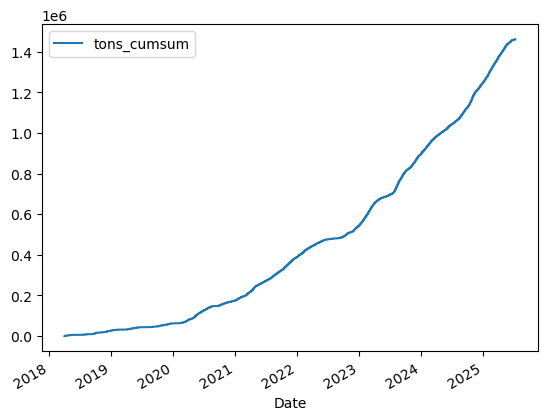

In [58]:
harvest_war_df.plot(x='Date', y='tons_cumsum')

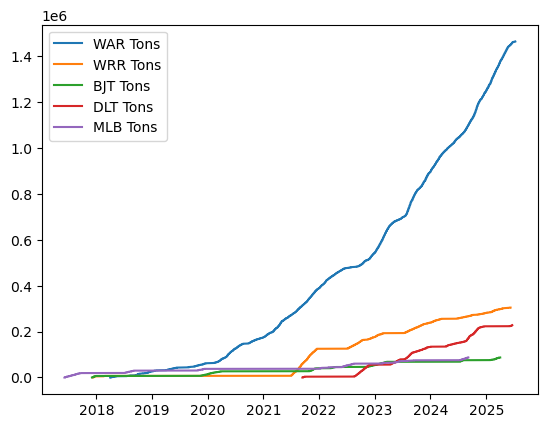

In [59]:
import matplotlib.pyplot as plt
war_harvest = harvest_df.loc[(harvest_df['TicketID'].str.contains("WAR"))].copy()
wrr_harvest = harvest_df.loc[(harvest_df['TicketID'].str.contains("WRR"))].copy()
bjt_harvest = harvest_df.loc[(harvest_df['TicketID'].str.contains("BJT"))].copy()
dlt_harvest = harvest_df.loc[harvest_df['TicketID'].str.contains("DLT")].copy()
mlb_harvest = harvest_df.loc[harvest_df['TicketID'].str.contains("MLB")].copy()
war_harvest = war_harvest.sort_values(by="Date")
wrr_harvest = wrr_harvest.sort_values(by="Date")
bjt_harvest = bjt_harvest.sort_values(by="Date")
dlt_harvest = dlt_harvest.sort_values(by="Date")
mlb_harvest = mlb_harvest.sort_values(by="Date")
war_harvest['tons_cumsum'] = war_harvest['Tons (U.S)'].cumsum()
wrr_harvest['tons_cumsum'] = wrr_harvest['Tons (U.S)'].cumsum()
bjt_harvest['tons_cumsum'] = bjt_harvest['Tons (U.S)'].cumsum()
dlt_harvest['tons_cumsum'] = dlt_harvest['Tons (U.S)'].cumsum()
mlb_harvest['tons_cumsum'] = mlb_harvest['Tons (U.S)'].cumsum()

fig, ax = plt.subplots()
ax.plot(war_harvest['Date'], war_harvest['tons_cumsum'], label='WAR Tons')
ax.plot(wrr_harvest['Date'], wrr_harvest['tons_cumsum'], label='WRR Tons')
ax.plot(bjt_harvest['Date'], bjt_harvest['tons_cumsum'], label='BJT Tons')
ax.plot(dlt_harvest['Date'], dlt_harvest['tons_cumsum'], label='DLT Tons')
ax.plot(mlb_harvest['Date'], mlb_harvest['tons_cumsum'], label="MLB Tons")
ax.legend()


In [60]:
harvest_df['project'] = harvest_df['TicketID'].str[:3]

In [61]:
harvest_df.groupby(["Reporting Period", 'project'])['Tons (U.S)'].sum()

Reporting Period  project
1                 BJT          6561.16000
                  DLT          3477.90000
                  WRR          6742.35000
2                 DLT         52145.25700
                  WAR          5473.11000
3                 BJT         20241.83000
                  DLT         78300.46859
                  MLB         19253.11000
                  WAR         37813.91000
4                 DLT         93668.79700
                  MLB         10645.96000
                  WAR         79671.06000
5                 BJT         18764.73000
                  MLB          7667.55900
                  WAR        145187.66000
                  WRR        118104.55000
6                 BJT         22554.64300
                  WAR        207275.13000
                  WRR         67942.98000
7                 WAR        216788.76000
                  WRR         63343.45800
8                 BJT         18822.38600
                  MLB         22710.39700
        

In [62]:
harvest_df['year'] = harvest_df['Date'].dt.year

<Axes: xlabel='project'>

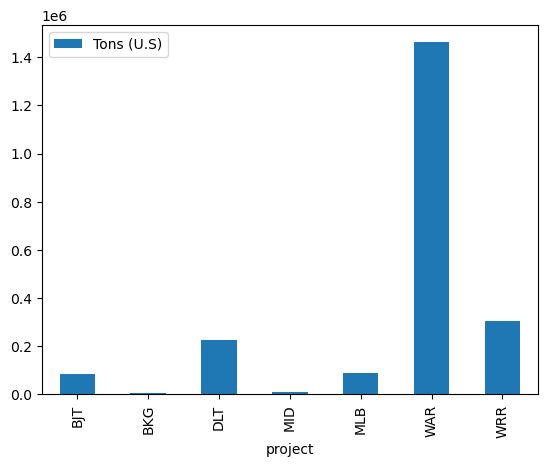

In [63]:
year_tons = harvest_df.groupby(['year', 'project'])['Tons (U.S)'].sum().reset_index()
year_tons.groupby('project')['Tons (U.S)'].sum().reset_index().plot(kind='bar', x='project', y='Tons (U.S)')

In [64]:
harvest_df.columns

Index(['index', 'Date', 'Ticket', 'Mill', 'Product', 'Tons (U.S)', 'Cull Tons',
       'Accepted Tons', 'Source', 'Notes', 'Reporting Period', 'TicketID',
       'Week', 'project', 'year'],
      dtype='object')

In [65]:
mill_list = harvest_df['Mill'].unique().tolist()
mill_dict = {}
mill_dict['mill'] = mill_list
mill_df = pd.DataFrame(mill_dict)
mill_df['mill_uid'] = mill_df.index
mill_mapper = dict(zip(mill_df['mill'], mill_df['mill_uid']))
harvest_df['mill'] = harvest_df['Mill'].map(mill_mapper)
harvest_df.drop(columns=['Mill'], inplace=True)

In [66]:
harvest_df['Week'] = harvest_df['Week'].astype(str)
harvest_df.loc[harvest_df['Week'] == 'Week3b', 'Week'] = "3"
harvest_df.loc[harvest_df['Week'] == 'Week2B', 'Week'] = "2"
def weeker(week):
    if "Week" in week:
        x = week.split("k")[1]
        x = int(x)
        return x
    elif "nan" in week:
        return 0
    else:
        return int(week)
    
harvest_df['Week_trial'] = harvest_df['Week'].apply(lambda x: weeker(x))

# I am not sure if I want to normalize the week or just leave it as the integer it is...
'''week_list = harvest_df['Week_trial'].unique().tolist()
week_dict = {}
week_dict['week'] = week_list
week_df = pd.DataFrame(week_dict)
week_df['week_uid'] = week_df.index
week_mapper = dict(zip(week_df['week'], week_df['week_uid']))
harvest_df['week'] = harvest_df['Week_trial'].map(week_mapper)'''

harvest_df['week'] = harvest_df['Week_trial']

In [67]:
product_list = harvest_df['Product'].unique().tolist()
product_dict = {}
product_dict['product'] = product_list
product_df = pd.DataFrame(product_dict)
product_df['product_uid'] = product_df.index
product_mapper = dict(zip(product_df['product'], product_df['product_uid']))
harvest_df['product'] = harvest_df['Product'].map(product_mapper)

In [83]:
#Map TicketID UID to harvest data
ticket_id_mapper = dict(zip(ticketid_df['ticketid'], ticketid_df['ticketid_uid']))
harvest_df['ticketid'] = harvest_df['TicketID'].map(ticket_id_mapper)
# Map the project UID to harvest data (to help make it easier to calculate by client)
project_id_mapper = dict(zip(project_df['project'], project_df['proj_uid']))
harvest_df['proj'] = harvest_df['TicketID'].str[:3]
harvest_df['project'] = harvest_df['proj'].map(project_id_mapper)
harvest_df['ticketid'] = harvest_df['ticketid'].astype(int)
harvest_df.drop(columns=['Product', 'TicketID', 'Week', 'Week_trial', 'index', 'proj'],inplace=True)
harvest_df.rename(columns={'Tons (U.S)': 'total_tons'})
harvest_df['harvest_uid'] = harvest_df.index

KeyError: "['Week_trial'] not found in axis"

In [70]:
harvest_df

,Date,Ticket,Tons (U.S),Cull Tons,Accepted Tons,Source,Notes,Reporting Period,project,year,mill,week,product,ticketid,harvest_uid
0,2018-04-02,559174,29.13,0.0,29.13,HMWCFI_RP2_Harvest_Grp1.pdf,NaN,2,0,2018.0,0,1,0,476,0
1,2018-04-03,559404,28.36,0.0,28.36,HMWCFI_RP2_Harvest_Grp1.pdf,NaN,2,0,2018.0,0,1,0,476,1
2,2018-04-06,560824,30.21,0.0,30.21,HMWCFI_RP2_Harvest_Grp1.pdf,NaN,2,0,2018.0,0,1,0,476,2
3,2018-04-04,559994,29.31,0.0,29.31,HMWCFI_RP2_Harvest_Grp1.pdf,NaN,2,0,2018.0,0,1,0,476,3
4,2018-04-04,559849,31.89,0.0,31.89,HMWCFI_RP2_Harvest_Grp1.pdf,NaN,2,0,2018.0,0,1,0,476,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73363,2023-06-12,152990,30.52,0.0,30.52,MID230119CCXX_Week04.pdf,NaN,9,6,2023.0,196,4,7,479,73363
73364,2023-06-12,152999,29.45,0.0,29.45,MID230119CCXX_Week04.pdf,NaN,9,6,2023.0,196,4,7,479,73364
73365,2023-06-12,153010,31.38,0.0,31.38,MID230119CCXX_Week04.pdf,NaN,9,6,2023.0,196,4,7,479,73365
73366,2023-06-12,153011,29.22,0.0,29.22,MID230119CCXX_Week04.pdf,NaN,9,6,2023.0,196,4,7,479,73366


In [71]:
# Send harvest data to db

harvest_df.to_sql('harvest_vol', conn, if_exists='replace', index=False, dtype={'harvest_uid':'INTEGER PRIMARY KEY', 'ticketid': 'INTEGER'})
product_df.to_sql('product', conn, if_exists='replace', index=False, dtype={'product_uid': 'INTEGER PRIMARY KEY'})
mill_df.to_sql('mill', conn, if_exists='replace', index=False, dtype={'mill_uid': 'INTEGER PRIMARY KEY'})

197

## Time to make the Expected Tons / RP table


My plan:
- Get the previous RP expected simply from MSS 
- Current RP pull from files I made for Rob

So if I can join MSS.groupby(["TicketID", "RP"])['Current RP Expected Tons'].sum() to mill_ticket.groupby(['TicketID', 'RP'])['Harvested Tons'].sum() AND MSS.groupb(['TICKETID', "RP"])['Future Tons'].sum() (which will be current RP + 1) I should be able to calculate the rolling expected tons by RP by TicketID - if not by UniqueID



In [72]:
mss_df.head()

,row_id,parent_id,IntakeID,FolderID,UniqueID,TicketID,Tract,CMP,Stand,Acres,...,Applied GA_ACRES,PstBA,PstTPA,PstGTA,RP Completed,Notes,Completed Date,Modified,Modified By,project
0,3399997202861956,,WAR241025,WAR241025b,WAR241025HD09,WAR241025HDXY,Clinch,3,10,68.0,...,,,,,,,,2025-07-24T21:15:47Z,bbrown@green-assets.com,WAR
1,8726216211402628,,WAR241025,WAR241025b,WAR241025HD07,WAR241025HDXY,Clinch,3,6,124.0,...,,,,,,,,2025-07-24T21:15:47Z,bbrown@green-assets.com,WAR
2,6486871802875780,,WAR241025,WAR241025b,WAR241025HD06,WAR241025HDXY,Clinch,3,5,136.0,...,,,,,,,,2025-07-24T21:15:47Z,bbrown@green-assets.com,WAR
3,651207655952260,,WAR250620,WAR250620,WAR250620TH02,WAR250620THXX,WACO,4586,7,25.74,...,,,,,,,,2025-07-24T13:17:15Z,bbrown@green-assets.com,WAR
4,2753684651380612,,WAR250310,WAR250310b,WAR250310BI03,WAR250310BI03,13078,NP,33,218.52,...,,,,,,This activity was replaces by WAR250606BI01.Th...,,2025-07-24T12:59:13Z,bbrown@green-assets.com,WAR


In [73]:
mss_df.columns

Index(['row_id', 'parent_id', 'IntakeID', 'FolderID', 'UniqueID', 'TicketID',
       'Tract', 'CMP', 'Stand', 'Acres', 'Age', 'GA_ACRES', 'County', 'State',
       'Plot Numbers', 'Status', 'Guidance', 'Expiration', 'GuidanceProvider',
       'SpecialPrescription', 'Scheduled', 'Species', 'Origin', 'PreBA',
       'PreTPA', 'PreGTA', 'PlnBA', 'PlnTPA', 'PlnGTA', 'Client GT', 'GA GT',
       'Current RP Expected GT', 'Future GT', 'Total GT', 'Timeframe',
       'Reporting Period', 'Activity Implemented', 'Applied GA_ACRES', 'PstBA',
       'PstTPA', 'PstGTA', 'RP Completed', 'Notes', 'Completed Date',
       'Modified', 'Modified By', 'project'],
      dtype='object')

In [74]:
current_expected = data_df.groupby(['TicketID', 'Reporting Period', 'Status'])['Current RP Expected GT'].sum().reset_index()
current_expected.head()

,TicketID,Reporting Period,Status,Current RP Expected GT
0,,0,,
1,BJT010101TH02,4,COMPLETED,
2,BJT010101TH05,3,COMPLETED,
3,BJT170000XXXX,0,EXPIRED,
4,BJT170000XXXX,1,COMPLETED,


In [75]:
future_expected = data_df.groupby(['TicketID', 'Reporting Period'])['Future GT'].sum().reset_index()
future_expected['Reporting Period'] = future_expected['Reporting Period'] + 1
future_expected[future_expected['Future GT'] > 0][:10]

,TicketID,Reporting Period,Future GT
215,WAR210218XXXX,6,7876.20000
236,WAR220809CC01,1,500.00000
237,WAR220809CC02,1,2912.00000
243,WAR220827TH02,1,155.00000
271,WAR230811CCXX,9,4443.00005
272,WAR230811TN01,9,89.52000
273,WAR230811TN02,9,580.85000
274,WAR230811TN03,9,329.64000
286,WAR231004CCXX,9,1779.00000
287,WAR231004TN01,9,569.00000


In [76]:
trial = pd.merge(current_expected, future_expected, left_on=['TicketID', 'Reporting Period'], right_on=['TicketID', 'Reporting Period'], how='left')
trial['Current RP Expected GT'] = pd.to_numeric(trial['Current RP Expected GT'], errors='coerce')
trial['Current RP Expected GT'].fillna(0, inplace=True)
trial['Future GT'].fillna(0, inplace=True)
trial['total_expected'] = trial['Current RP Expected GT'] + trial['Future GT']
trial.tail()

,TicketID,Reporting Period,Status,Current RP Expected GT,Future GT,total_expected
594,WRR250317CC01,8,IN PROCESS,2348.61,0.0,2348.61
595,WRR250409CC01,8,IN PROCESS,3076.08,0.0,3076.08
596,WRR250421CC01,8,Out of Project Area,0.00,0.0,0.00
597,WRR250428TH01,8,Out of Project Area,0.00,0.0,0.00
598,WRR250522TH01,8,IN PROCESS,4098.31,0.0,4098.31


In [77]:
trial[trial['Reporting Period'] > 9]

,TicketID,Reporting Period,Status,Current RP Expected GT,Future GT,total_expected
34,BKG220831THXX,10,COMPLETED,0.00,0.0,0.00
161,MLB241122CC01,10,IN PROCESS,0.00,0.0,0.00
371,WAR250310TH01,10,OPEN,26961.43,0.0,26961.43
377,WAR250527TH01,10,OPEN,4528.00,0.0,4528.00
379,WAR250616BIXX,10,OPEN,19294.17,0.0,19294.17
380,WAR250616BIXY,10,OPEN,19297.00,0.0,19297.00
381,WAR250620THXX,10,IN PROCESS,2608.14,0.0,2608.14
382,WAR250716TH01,10,PENDING,2280.02,0.0,2280.02


In [78]:
# Ok, now let's get in the harvest data and then anything that has a difference > 0 and is IN PROCESS or OPEN
# will be pushed to the next RP
harvest_df.head()

,Date,Ticket,Tons (U.S),Cull Tons,Accepted Tons,Source,Notes,Reporting Period,project,year,mill,week,product,ticketid,harvest_uid
0,2018-04-02,559174,29.13,0.0,29.13,HMWCFI_RP2_Harvest_Grp1.pdf,NaN,2,0,2018.0,0,1,0,476,0
1,2018-04-03,559404,28.36,0.0,28.36,HMWCFI_RP2_Harvest_Grp1.pdf,NaN,2,0,2018.0,0,1,0,476,1
2,2018-04-06,560824,30.21,0.0,30.21,HMWCFI_RP2_Harvest_Grp1.pdf,NaN,2,0,2018.0,0,1,0,476,2
3,2018-04-04,559994,29.31,0.0,29.31,HMWCFI_RP2_Harvest_Grp1.pdf,NaN,2,0,2018.0,0,1,0,476,3
4,2018-04-04,559849,31.89,0.0,31.89,HMWCFI_RP2_Harvest_Grp1.pdf,NaN,2,0,2018.0,0,1,0,476,4


In [ ]:
harvest_ticketid = harvest_df.groupby(['TicketID', 'Reporting Period'])['Tons (U.S)'].sum().reset_index()

KeyError: 'UniqueID'

In [87]:
trial_w_harvest = pd.merge(trial, harvest_ticketid, how='left', left_on=['TicketID', 'Reporting Period'], right_on=['TicketID', 'Reporting Period'])
trial_w_harvest[trial_w_harvest['TicketID'] == 'WRR250317CC01']

,TicketID,Reporting Period,Status,Current RP Expected GT,Future GT,total_expected,Tons (U.S)
594,WRR250317CC01,8,IN PROCESS,2348.61,0.0,2348.61,1825.44


In [88]:
trial_w_harvest['difference'] = trial_w_harvest['total_expected'] - trial_w_harvest['Tons (U.S)']

In [89]:
trial_w_harvest[(trial_w_harvest['difference'] > 0) & (trial_w_harvest['Status'].isin(['COMPLETED']))]

,TicketID,Reporting Period,Status,Current RP Expected GT,Future GT,total_expected,Tons (U.S),difference
30,BJT241022CCXX,8,COMPLETED,4401.62,0.0,4401.62,3417.26600,984.35400
53,DLT221203TH06,3,COMPLETED,4920.00,0.0,4920.00,3849.23000,1070.77000
54,DLT221203TH09,3,COMPLETED,6600.00,0.0,6600.00,4694.32000,1905.68000
55,DLT221203TH10,3,COMPLETED,2150.00,0.0,2150.00,2039.24015,110.75985
56,DLT221203TH11,3,COMPLETED,2450.00,0.0,2450.00,1420.96000,1029.04000
86,DLT230410TTXX,3,COMPLETED,8730.00,0.0,8730.00,7922.90000,807.10000
90,DLT230511TH03,3,COMPLETED,4250.00,0.0,4250.00,3390.19300,859.80700
105,DLT241007HD08,4,COMPLETED,7205.00,0.0,7205.00,1339.56000,5865.44000
107,DLT241007HDXX,4,COMPLETED,22794.09,0.0,22794.09,4829.05800,17965.03200
108,DLT241023HD01,4,COMPLETED,2582.14,0.0,2582.14,513.68700,2068.45300


In [90]:
trial_w_harvest.to_excel("expected_with_harvest.xlsx")

I think we need to discover when activities were completed which - I think - means I need to bring in the Applied All feature class from GAS to determine the final RP that an activity was active


In [107]:
import pandas as pd
applied_rp_df = pd.read_excel("applied_rp.xlsx")
applied_rp_df.head()

,Unnamed: 0,UNIQUE_ID,RP
0,0,BJT170224TH01,1
1,1,BJT190424TH01,4
2,2,BJT190424TH03,3
3,3,BJT190424TH04,3
4,4,BJT190424TH05,3


In [108]:
unique_2_ticket = pd.read_sql('SELECT * FROM ticketid_lookup_activityid', conn)
applied_rp_df = pd.merge(applied_rp_df, unique_2_ticket, how='left', left_on='UNIQUE_ID', right_on='ticket_lookup_uid')

In [109]:
ticketid_lookup = pd.read_sql('SELECT * FROM ticketid', conn)
ticketid_lookup

,ticketid,ticketid_uid,tcs
0,WAR241025HDXY,0,352
1,WAR250620THXX,1,371
2,WAR250310BI03,2,359
3,WAR250310BI02,3,358
4,WAR250310BI01,4,357
...,...,...,...
578,WRR240109TT01,578,542
579,WRR240325BN01,579,545
580,WRR240318BN02,580,544
581,WRR240318BN01,581,543


In [110]:
applied_rp_df.head()

,Unnamed: 0,UNIQUE_ID,RP,ticket_lookup_uid,ticketid
0,0,BJT170224TH01,1,NaN,NaN
1,1,BJT190424TH01,4,BJT190424TH01,573.0
2,2,BJT190424TH03,3,BJT190424TH03,573.0
3,3,BJT190424TH04,3,BJT190424TH04,573.0
4,4,BJT190424TH05,3,BJT190424TH05,573.0


In [111]:
applied_rp_df = pd.merge(applied_rp_df, ticketid_lookup, how='left', left_on='ticketid', right_on='ticketid_uid')

In [112]:
applied_rp_df.head()

,Unnamed: 0,UNIQUE_ID,RP,ticket_lookup_uid,ticketid_x,ticketid_y,ticketid_uid,tcs
0,0,BJT170224TH01,1,NaN,NaN,NaN,NaN,NaN
1,1,BJT190424TH01,4,BJT190424TH01,573.0,BJT190000XXXX,573.0,4.0
2,2,BJT190424TH03,3,BJT190424TH03,573.0,BJT190000XXXX,573.0,4.0
3,3,BJT190424TH04,3,BJT190424TH04,573.0,BJT190000XXXX,573.0,4.0
4,4,BJT190424TH05,3,BJT190424TH05,573.0,BJT190000XXXX,573.0,4.0


In [115]:
applied_rp_df = applied_rp_df.groupby('ticketid_y')['RP'].max().reset_index()

In [116]:
applied_rp_df.to_excel("applied_max_rp.xlsx")

{'WAR241025HDXY': 0,
 'WAR250620THXX': 1,
 'WAR250310BI03': 2,
 'WAR250310BI02': 3,
 'WAR250310BI01': 4,
 'BJT250221CCXX': 5,
 'WAR241025HDXX': 6,
 'WRR240802TH07': 7,
 'WRR240802TH06': 8,
 'WRR240802TH05': 9,
 'WRR240802TH03': 10,
 'WRR240802TH02': 11,
 'WRR240802TH01': 12,
 'WRR240709XXXX': 13,
 'WRR240709CCXX': 14,
 'WRR240404TH02': 15,
 'WRR240404TH01': 16,
 'WRR240101XXXX': 17,
 'WRR240101TT01': 18,
 'WRR240101TH02': 19,
 'WRR240101TH01': 20,
 'WRR231107XXXX': 21,
 'WRR231107TH01': 22,
 'WRR231107CC01': 23,
 'WRR230829TH02': 24,
 'WRR230829TH01': 25,
 'WRR230829CCXX': 26,
 'WAR250616BIXY': 27,
 'WAR250616BIXX': 28,
 'WRR250409CC01': 29,
 'WRR250130CCXX': 30,
 'WAR250716TH01': 31,
 'WAR240702BI02': 32,
 'WAR240702BI01': 33,
 'WAR240521TT01': 34,
 'WAR240524TT01': 35,
 'WAR240524TH01': 36,
 'DLT241211TT06': 37,
 'WAR241025HDXZ': 38,
 'MFV250528CC05': 39,
 'MFV250528CC03': 40,
 'MFV250528CC02': 41,
 'DLT241211TT09': 42,
 'DLT241211CCXX': 43,
 'DLT250305TH01': 44,
 'DLT241211TT10': 45

In [ ]:
# The following should get me up to RP9 for WAR
war_expected_inprog = data_df[(~data_df['Reporting Period'].isna()) & (data_df['UniqueID'].str.contains("WAR"))].copy()
war_expected_inprog = war_expected_inprog[war_expected_inprog['Reporting Period'] != 10]
war_expected_inprog = war_expected_inprog[['TicketID', 'Reporting Period', 'Current RP Expected GT']]
war_expected_inprog = war_expected_inprog[war_expected_inprog['Current RP Expected GT'] != ""]
war_expected_inprog = war_expected_inprog.groupby(['TicketID', 'Reporting Period'])['Current RP Expected GT'].sum().reset_index()

In [ ]:
war_expected_inprog.head()

In [ ]:
war_expected_inprog.to_excel("war_expected_looksie.xlsx")

In [ ]:
war_expected_rp9 = pd.read_excel(r"./WAR_RP9_InProcess/Excel_sheets/rp9_investigate_matchesRob.xlsx", sheet_name='Sheet2')
war_expected_rp9.rename(columns=({'RP9 Expected': 'Current RP Expected GT'}), inplace=True)

In [ ]:
war_expected_rp9['Reporting Period'] = 9
war_expected_rp9, war_expected_rp9['Current RP Expected GT'].sum()

In [ ]:
# Join the two together - though it will not account for any carryover pre- RP8 ( i am pretty sure I brute forced the RP8 to be correct for reporting purposes)
war_expected = pd.concat([war_expected_inprog, war_expected_rp9])


In [ ]:
# Let's do WRR
wrr_expected_inprog = data_df[(~data_df['Reporting Period'].isna()) & (data_df['UniqueID'].str.contains("WRR"))].copy()
wrr_expected_inprog = wrr_expected_inprog[wrr_expected_inprog['Reporting Period'] != 8]
wrr_expected_inprog = wrr_expected_inprog[['TicketID', 'Reporting Period', 'Current RP Expected GT']]
wrr_expected_inprog = wrr_expected_inprog[wrr_expected_inprog['Current RP Expected GT'] != ""]
wrr_expected_inprog = wrr_expected_inprog.groupby(['TicketID', 'Reporting Period'])['Current RP Expected GT'].sum().reset_index()

# Current rp
wrr_current_rp = pd.read_excel(r"C:\Users\bbrown\Documents\python_scripts\db-build-trial\WRR_RP8_InProcess\WRR_to_db_241202.xlsx")

In [ ]:
wrr_expected = pd.concat([wrr_expected_inprog, wrr_current_rp])

In [ ]:
wrr_expected.loc[wrr_expected['Reporting Period'] == 8, 'Current RP Expected GT'].sum()

In [ ]:
# Time for BJT
# previous rp expected
bjt_expected_inprog = data_df[(~data_df['Reporting Period'].isna()) & (data_df['UniqueID'].str.contains("BJT"))].copy()
bjt_expected_inprog = bjt_expected_inprog[bjt_expected_inprog['Reporting Period'] != 8]
bjt_expected_inprog = bjt_expected_inprog[['TicketID', 'Reporting Period', 'Current RP Expected GT']]
bjt_expected_inprog = bjt_expected_inprog[bjt_expected_inprog['Current RP Expected GT'] != '']
bjt_expected_inprog = bjt_expected_inprog.groupby(['TicketID', 'Reporting Period'])['Current RP Expected GT'].sum().reset_index()

# current rp expected
bjt_current_rp = pd.read_excel(r"C:\Users\bbrown\Documents\python_scripts\db-build-trial\BJT_RP8_InProcess\BJT_RP8_requestvol_241202.xlsx")

In [ ]:
bjt_expected_df = pd.concat([bjt_expected_inprog, bjt_current_rp])

In [ ]:
# Group all of the expected into a single table

total_expected = pd.concat([war_expected, wrr_expected, bjt_expected_df])

In [ ]:
total_expected.reset_index(inplace=True)
total_expected['gt_expected_uid'] = total_expected.index
# Normalize the ticketid
total_expected['ticketid'] = total_expected['TicketID'].map(ticket_id_mapper)
total_expected.to_excel("expected_lookup.xlsx")
total_expected['ticketid'] = total_expected['ticketid'].astype(int)
total_expected = total_expected.rename(columns={'Reporting Period': 'reporting_period', 'Current RP Expected GT': 'expected_gt'})
total_expected = total_expected[['gt_expected_uid', 'ticketid', 'reporting_period', 'expected_gt']]





total_expected.to_sql('gt_expected', conn, index=False, if_exists='replace', dtype={'gt_expected_uid': 'INTEGER PRIMARY KEY'})